# Regularyzacja w modelu regresji - zbiór `longley`

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Zadanie - `longley`

Zbiór danych `longley` zawiera różne zmienne makroekonomiczne w USA, o których wiadomo, że są wysoce współliniowe.

`GNPDEFL` GNP implicit price deflator (1954=100)

`GNP` Gross National Produc

`UNEMP` number of unemployed.

`ARMED` number of people in the armed forces.

`POP` ‘noninstitutionalized’ population ≥ 14 years of age.

`YEAR` the year (time).

`TOTEMP` number of people employed.

1. Dopasuj model regresji liniowej, w którym zmienną zależną jest zmienna `TOTEMP` a pozostałe cechy zmiennymi niezależnymi. Wyznacz ocenę dopasowania modelu korzystając z kroswalidacji 10-krotnej dla następujących miar:
   - błędu średniokwadratowego, 
   - mediany błędu bezwzględnego, 
   
    
2. Dopasuj model regresji grzbietowej:
   - znajdź optymalną wartość parametru $\alpha$ (GridSearchCV)
   - sporządź wykres wartości współczynników regresji względem parametru $\alpha$.


3. Dopasuj model regresji Lasso:
   - znajdź optymalną wartość parametru $\alpha$ (GridSearchCV)
   - sporządź wykres wartości współczynników regresji względem parametru $\alpha$.
   
   
4. dopasuj model regresji wielomianowej
   - znajdź optymalny stopień wielomianu
   - zastosuj regularyzację - znajdź optymalny stopień wielomianu i parametr $\alpha$.
   
Rozwiązując powyższe zadanie staraj się automatyzować swoją analizę, tj. napisz funkcje:
- `cross_val_scores`, która zwraca słownik/ramkę danych miar jakości dla zbudowanego modelu;
- `grid_search_alpha`, która znajduje optymalną wartość $\alpha$ dla modelu regresji z regularyzacją Ridge lub Lasso;
- `grid_search_power_and_alpha`, która znajduje optymalny stopień wielomianu oraz parametr $alpha$ dla regresji wielomianowej z regularyzacją Ridge lub Lasso.

Przygotuj tak analizę aby na koniec przedstawić wszystkie wyniki w jednej tabeli.

In [2]:
longley = sm.datasets.longley.load_pandas()
longley.data.head()

,TOTEMP,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,60323.0,83.0,234289.0,2356.0,1590.0,107608.0,1947.0
1,61122.0,88.5,259426.0,2325.0,1456.0,108632.0,1948.0
2,60171.0,88.2,258054.0,3682.0,1616.0,109773.0,1949.0
3,61187.0,89.5,284599.0,3351.0,1650.0,110929.0,1950.0
4,63221.0,96.2,328975.0,2099.0,3099.0,112075.0,1951.0


In [3]:
#zmienna niezależne i zależna 
X, y = longley.data.iloc[:, longley.data.columns != 'TOTEMP'], longley.data['TOTEMP']

In [4]:
#funkcja licząca miary dla modelu
def cross_val_scores(model,X,y,cv = 10):
  results = {}
  results['mse'] = -cross_val_score(model,X,y,scoring = 'neg_mean_squared_error',cv = cv).mean()
  results['mae'] = -cross_val_score(model,X,y,scoring = 'neg_median_absolute_error',cv = cv).mean()
  return(results)

In [5]:
#funkcja mająca znaleźć najlepszą alphę w regresji ridge czy lasso za pomocą kroswalidacji (zwraca najlepszą alphę)
def grid_search_alpha(model,X,y,params,scoring,cv = 10):
  grid = GridSearchCV(
      make_pipeline(
          StandardScaler(),
          model
      ),
      params,
      scoring = scoring,
      cv = cv)
  grid.fit(X,y)
  return grid.best_params_

In [6]:
models = {}
#miary dla liniowego
models['linear'] = cross_val_scores(LinearRegression(),X,y)
#optymalna alpha dla ridge
best_alpha_ridge = grid_search_alpha(Ridge(),X,y,{'ridge__alpha':np.linspace(0.01,10,100)},
                                     scoring = 'neg_mean_squared_error',cv = 10)
#ridge z najlepszym parametrem
ridge = make_pipeline(
          StandardScaler(),
          Ridge(best_alpha_ridge['ridge__alpha']))
#miary dla ridge
models['ridge_%.3g' % best_alpha_ridge['ridge__alpha']] = cross_val_scores(ridge,X,y)
#optymalna alpha dla lasso
best_alpha_lasso = grid_search_alpha(Lasso(),X,y,{'lasso__alpha':np.linspace(0.01,10,100)},
                                     scoring = 'neg_mean_squared_error',cv = 10)
#lasso z najlepszym parametrem
lasso = make_pipeline(
          StandardScaler(),
          Lasso(best_alpha_lasso['lasso__alpha']))
#miary dla lasso
models['lasso_%.3g' % best_alpha_lasso['lasso__alpha']] = cross_val_scores(lasso,X,y)

In [7]:
pd.DataFrame(models)

,linear,ridge_0.01,lasso_7.78
mse,233948.331759,226644.930114,169051.042878
mae,394.109659,368.268979,297.792808


In [8]:
#funkcja do stworzenia wykresu zmiany wartości współczynnika beta w zależności od zmiany alpha
def plot_coef_vs_alpha(model_name, min_alpha, max_alpha, poly_degree=1):
    alpha_vec =  np.linspace(min_alpha, max_alpha, 100)
    
    if (model_name == 'lasso'):
        model = Lasso(max_iter=1e5)
    elif(model_name == 'ridge'):
        model = Ridge()

    coefs = []
    for a in alpha_vec:
        model.alpha = a
        
        model_reg = make_pipeline(
            PolynomialFeatures(poly_degree),
            StandardScaler(),
            model
        )
        
        model_reg.fit(X, y)
        coefs.append(model_reg.named_steps[model_name].coef_[1:])

    plt.plot(alpha_vec, coefs)
    plt.plot([np.min(alpha_vec), np.max(alpha_vec)], [0, 0], '-.', color = 'black')
    plt.xlabel('alpha')
    plt.ylabel('coefficients')
    plt.legend(X.columns)
    plt.show()

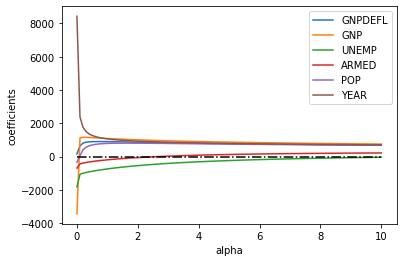

In [9]:
plot_coef_vs_alpha('ridge',0,10,1) #schodzą do 0

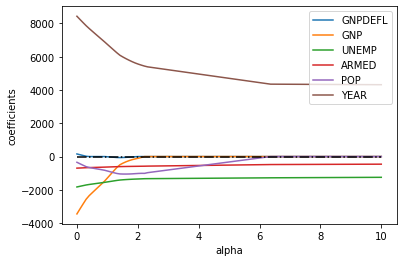

In [10]:
plot_coef_vs_alpha('lasso',0,10,1) #osiągają 0 jeden po drugim wraz ze wzrostem alphy

In [11]:
#funkcja do znajdywania najlepszego zestawu parametrów degree i alpha
def grid_search_power_and_alpha(model,X,y,params,scoring,cv = 10):
  grid = GridSearchCV(
      make_pipeline(
          PolynomialFeatures(),
          StandardScaler(),
          model
      ),
      params,
      scoring = scoring,
      cv = cv)
  grid.fit(X,y)
  return grid.best_params_

In [12]:
models2 = {}
#znajdujemy najlepsze parametrey modelu dla ridge
best_params_ridge = grid_search_power_and_alpha(
    model = Ridge(),
    X = X,
    y=y,
    params = {
        'ridge__alpha':np.linspace(0.01,1,10),
        'polynomialfeatures__degree':np.arange(1,11)
    },
    scoring = 'neg_mean_squared_error'
)

In [ ]:
best_params_ridge #najlepsze parametry

{'polynomialfeatures__degree': 1, 'ridge__alpha': 0.01}

In [13]:
#ridge polynomial z najlepszym zestawem parametrów
ridge = make_pipeline(
          PolynomialFeatures(best_params_ridge['polynomialfeatures__degree']),
          StandardScaler(),
          Ridge(best_params_ridge['ridge__alpha'])
)
#miary dla ridge
models2['ridge_%.3g_%d' % (best_params_ridge['ridge__alpha'],
                       best_params_ridge['polynomialfeatures__degree'])] = cross_val_scores(ridge,X,y)


In [17]:
#znajdujemy najlepsze parametrey modelu dla lasso
best_params_lasso = grid_search_power_and_alpha(
    model = Lasso(),
    X = X,
    y=y,
    params = {
        'lasso__alpha':np.linspace(7.01,8,10), #parametr szukam między 7 a 8, bo wcześniej alpha z tego przedziału dawała najlepsze wyniki
        'polynomialfeatures__degree':np.arange(1,11)
    },
    scoring = 'neg_mean_squared_error'
)

In [18]:
#lasso polynomial z najlepszym zestawem parametrów
lasso = make_pipeline(
          PolynomialFeatures(best_params_lasso['polynomialfeatures__degree']),
          StandardScaler(),
          Lasso(best_params_lasso['lasso__alpha'])
)
#miary dla lasso
models2['lasso_%.3g_%d' % (best_params_lasso['lasso__alpha'],
                       best_params_lasso['polynomialfeatures__degree'])] = cross_val_scores(lasso,X,y)

In [19]:
#wyniki końcowe
results = pd.concat([pd.DataFrame(models),pd.DataFrame(models2)],axis =1,sort = False)
results

,linear,ridge_0.01,lasso_7.78,ridge_0.01_1,lasso_0.56_1,lasso_7.78_1
mse,233948.331759,226644.930114,169051.042878,226644.930114,213884.633677,169051.042878
mae,394.109659,368.268979,297.792808,368.268979,358.733590,297.792808
